In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass

    if data.attrs["Hc"]<10:
        return None

    return data

def arrayToColors(data):

    data=(data-np.min(data))/(np.max(data)-np.min(data))
    return mpl.cm.plasma(np.array(data))

def getData():
    data=[]
    
    files=glob.glob("data/*")
    badFiles=[]

    for name in files:
        pointiness,temp=name.split("spacing")
        spacing,length=temp.split("length")
        pointiness=float(pointiness[15:-1])
        spacing=float(spacing[:-1])
        length=float(length[:-4])

        try:
            thisData=loadFile(name+"/table.txt")
            thisData.attrs["pointiness"]=pointiness
        
            thisData.attrs["spacing"]=spacing
            thisData.attrs["length"]=length
            data.append(thisData)
        except Exception as e:
            badFiles.append(name)
            continue


    print(f"Could not load {len(badFiles)}/{len(files)} file")
    return data

data=getData()

def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if i.attrs["pointiness"] not in pointinessVals: pointinessVals.append(i.attrs["pointiness"])
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals

pointinessVals, spacingVals, lengthVals = getPossibleVals(data)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framewor

Could not load 1/114 file


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [2]:
#pointiness, spacing, length


def getAttributeVals(name):
    values=set()
    for i in data: values.add(i.attrs[name])
    return sorted(list(values))

def getPlotsWithVal(name,value):
    return [i for i in data if i.attrs[name]==value]

def legendify(val):
    if val<1e-5: val*=1e9
    val=round(val,1)
    return val

def labelify(name):
    vals={
        "spacing":"Spacing (nm)",
        "length": "Length (nm)",
        "pointiness": "Pointiness",
        "Hc":"$H_c$",
        "Br":"$B_r",

    }
    if name in vals:
        return vals[name]
    else:
        return name

def plotData(yAxis,xAxis,colorAxis,plotAxis):
    xAxisVals=getAttributeVals(xAxis)
    yAxisVals=getAttributeVals(yAxis)
    colorAxisVals=getAttributeVals(colorAxis)
    plotAxisVals=getAttributeVals(plotAxis)



    fig, axs = plt.subplots(2,int(np.ceil(len(plotAxisVals)/2)),sharex=True,sharey=True)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0,wspace=0)

    fig.set_size_inches(14,8)

    for ax in axs.flat[len(plotAxisVals):]:
        ax.remove()



    colors = mpl.cm.jet(np.linspace(0,1,len(colorAxisVals)))
    colorLookup = dict(zip(colorAxisVals,colors))

    
    for ax,plotAxisVal in zip(axs.flat,plotAxisVals):
        plots=getPlotsWithVal(plotAxis,plotAxisVal)
        for colorAxisVal in colorAxisVals:
            thisColor=[plot for plot in plots if plot.attrs[colorAxis]==colorAxisVal]
            thisColor=sorted(thisColor,key=lambda plot:plot.attrs[xAxis])

            
            
            xVals=[legendify(i.attrs[xAxis]) for i in thisColor]
            yVals=[i.attrs[yAxis] for i in thisColor]

            ax.plot(xVals,yVals,"o-",label=f"{legendify(colorAxisVal)}",color=colorLookup[colorAxisVal])
        
        ax.text(.5,.95,f"{labelify(plotAxis)}={legendify(plotAxisVal)}",
        horizontalalignment='center',
        transform=ax.transAxes)
        #ax.set_xlabel(xAxis)
        #ax.set_ylabel(yAxis)
        #ax.set_xlim(min(xAxisVals),max(xAxisVals))
        #ax.set_ylim(min(yAxisVals),max(yAxisVals))
        #plt.axes().margins(y=0.1)

        plotAxisLabel=plotAxisVal
        if plotAxisLabel<1: plotAxisLabel*=1e9
        plotAxisLabel=round(plotAxisLabel)

        #plt.title()
    

    fig.text(0.5, 0, labelify(xAxis), ha='center')
    fig.text(0, 0.5, labelify(yAxis), va='center', rotation='vertical')

    handles, labels = ax.get_legend_handles_labels()
    plt.rcParams['legend.title_fontsize'] = 20
    fig.legend(handles, labels, loc='right',title=f'{labelify(colorAxis)}',fontsize=15)

    fig.suptitle(f"{labelify(yAxis)} vs. {labelify(xAxis)}",y=1.05)

    fig.subplots_adjust(right=0.85)

    

plotData("Hc","pointiness","length","spacing")
plotData("Hc","pointiness","spacing","length")
plotData("Hc","length","spacing","pointiness")
plotData("Hc","length","pointiness","spacing")
plotData("Hc","spacing","pointiness","length")
plotData("Hc","spacing","length","pointiness")


NameError: name 'data' is not defined

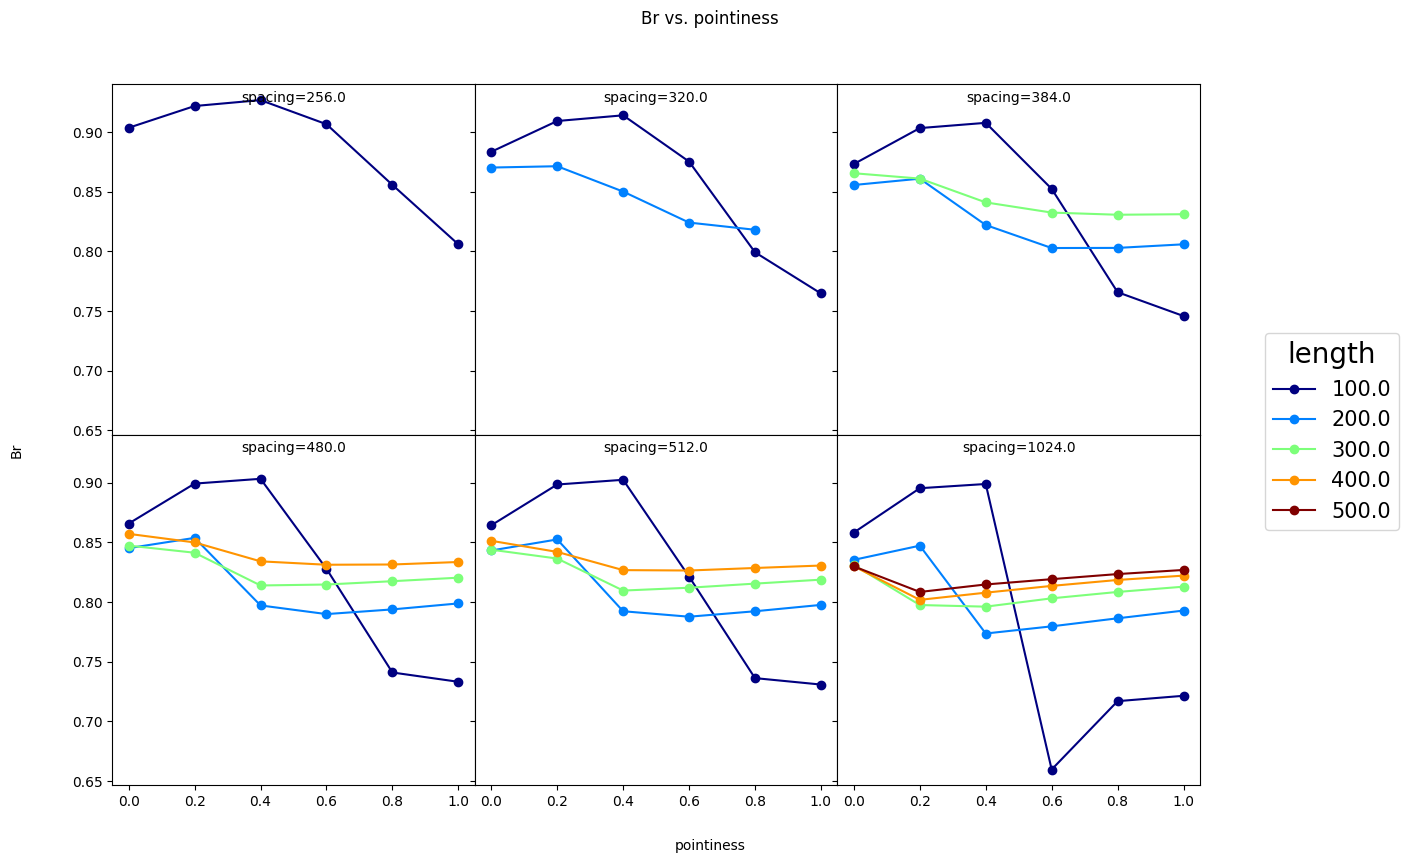

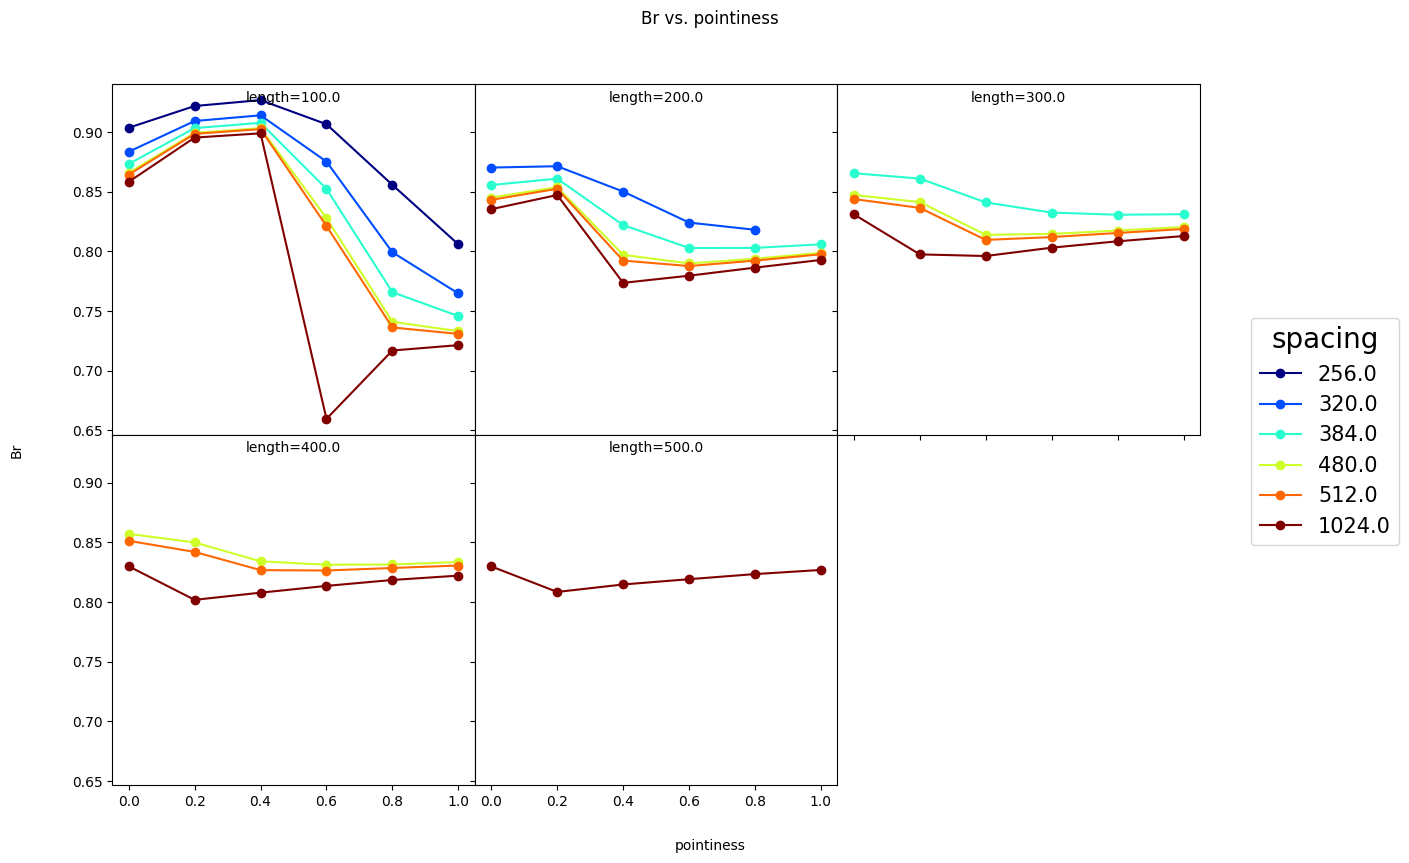

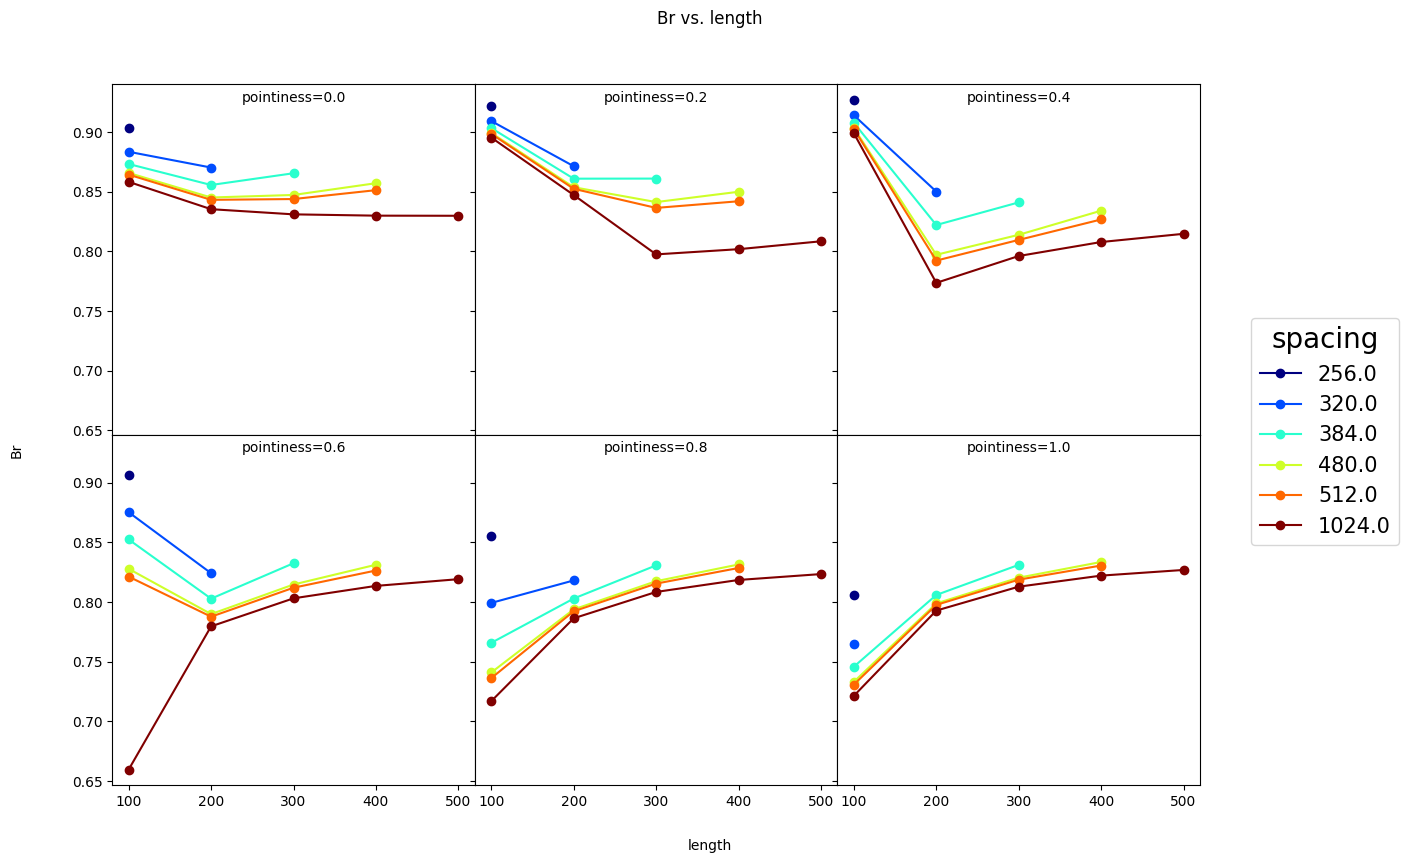

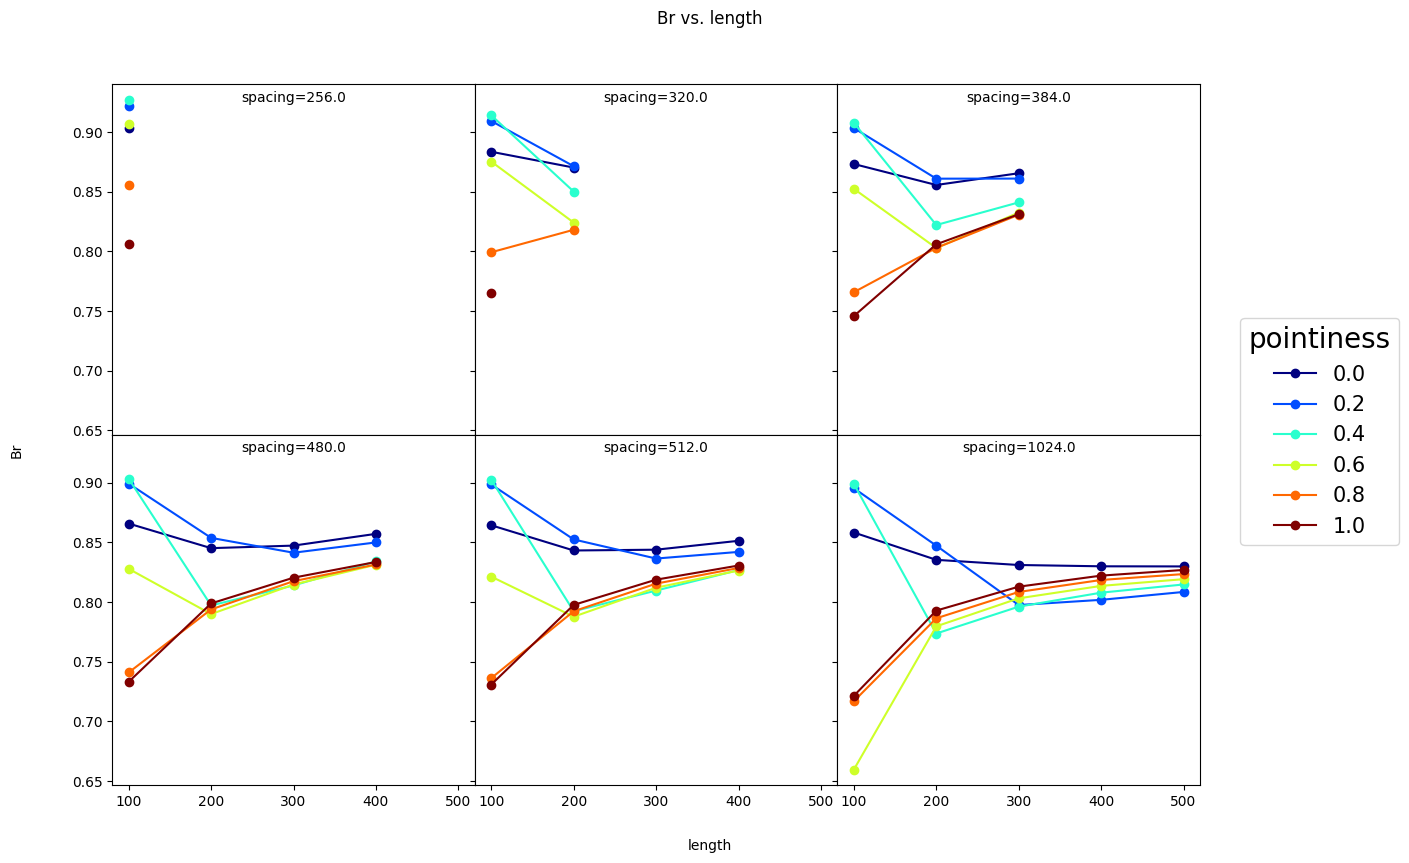

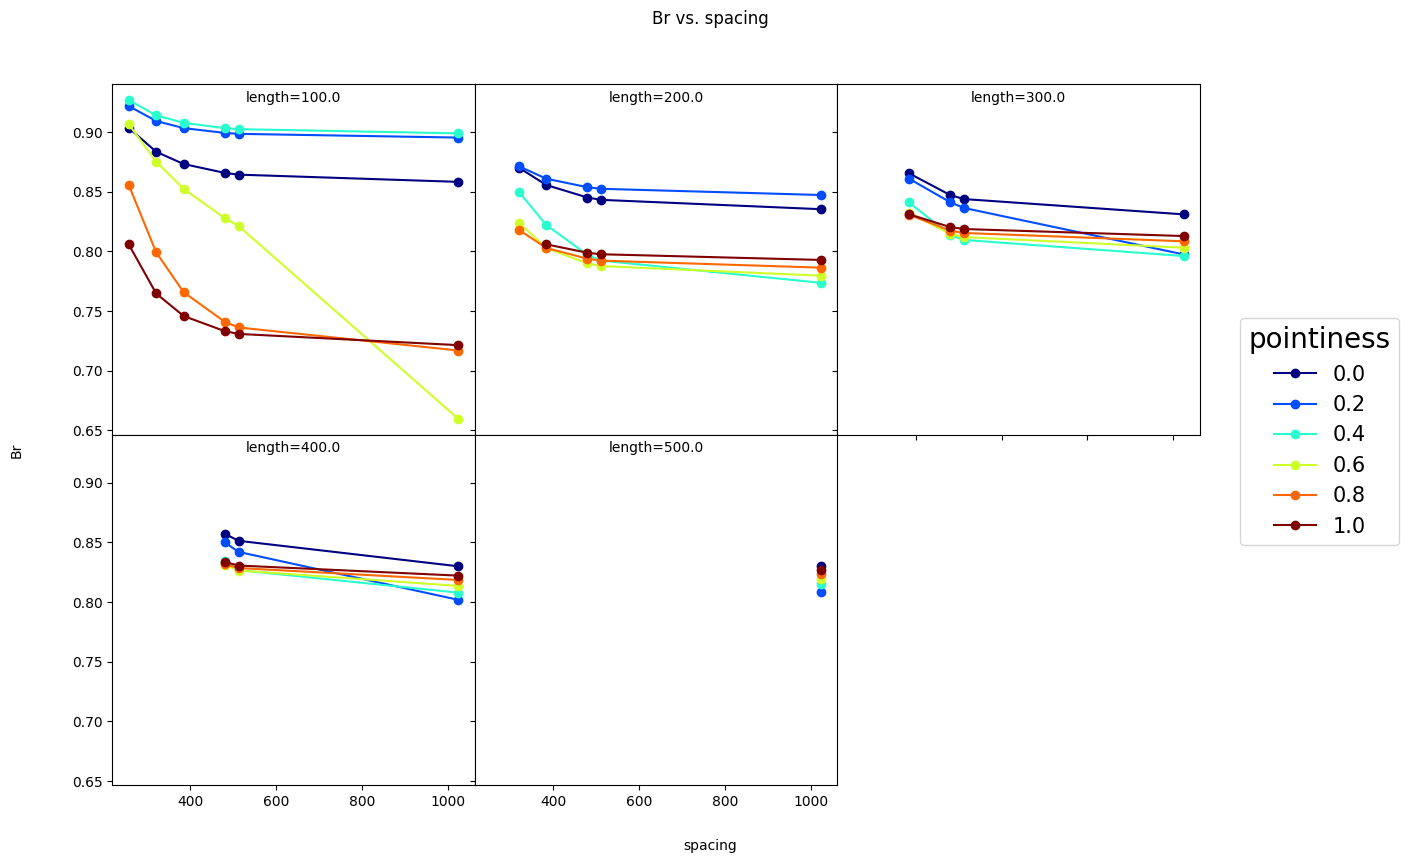

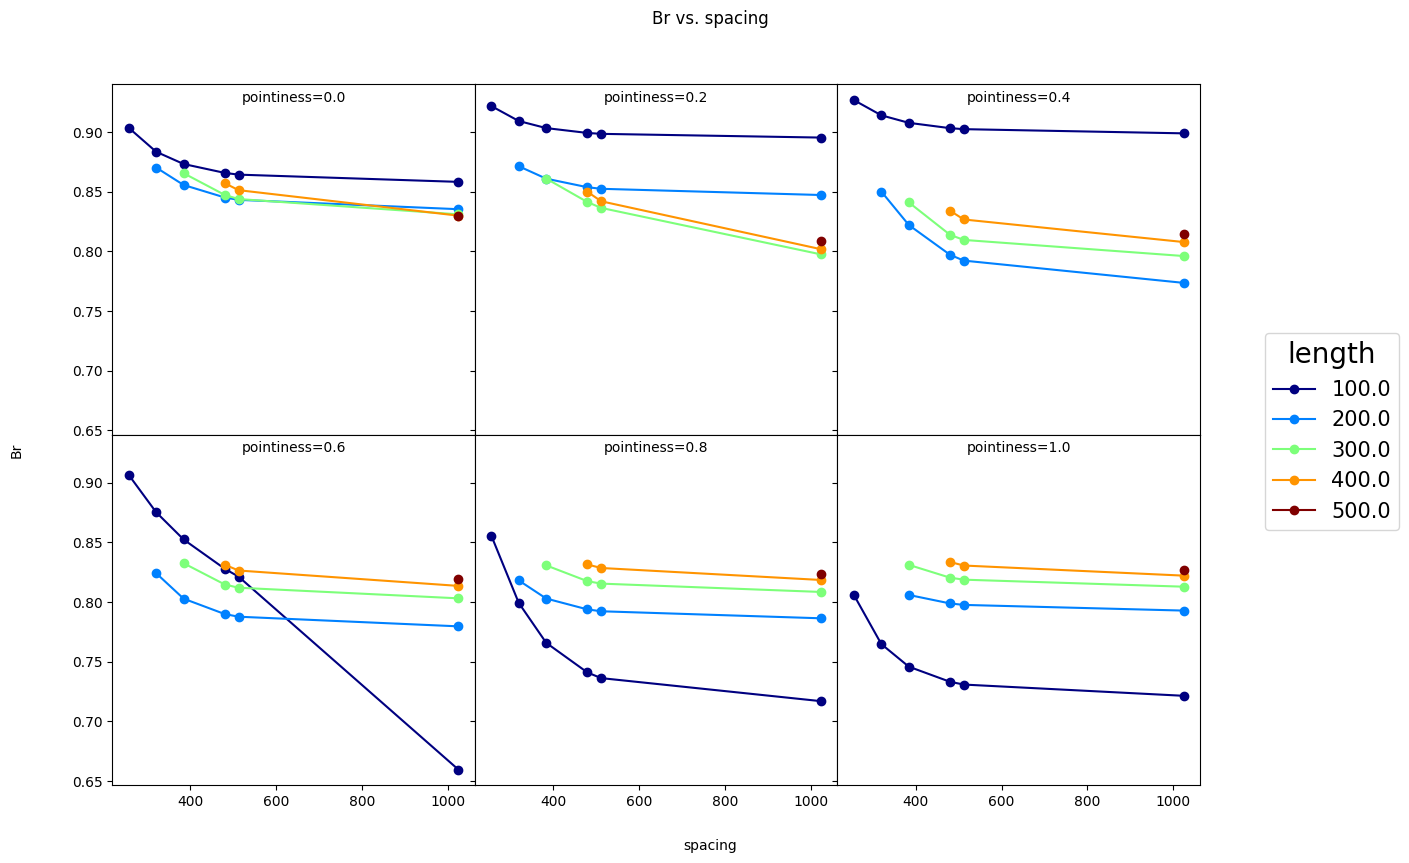

In [162]:
plotData("Br","pointiness","length","spacing")
plotData("Br","pointiness","spacing","length")
plotData("Br","length","spacing","pointiness")
plotData("Br","length","pointiness","spacing")
plotData("Br","spacing","pointiness","length")
plotData("Br","spacing","length","pointiness")

0


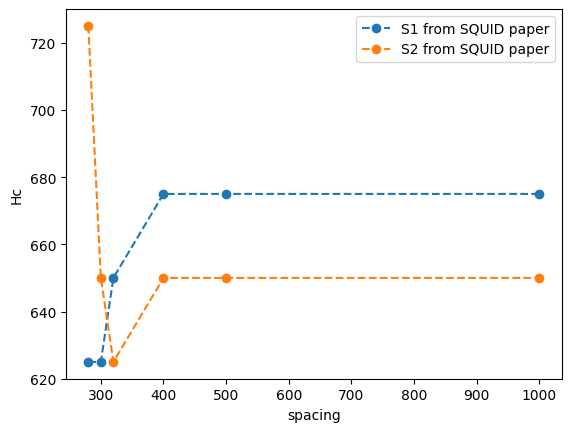

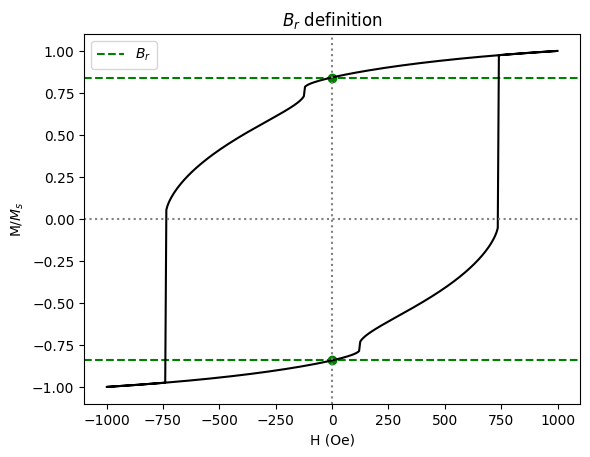

In [69]:
exampleData=data[0]
HcVals=[-exampleData.attrs["Hc"],exampleData.attrs["Hc"]]
BrVals=[-exampleData.attrs["Br"],exampleData.attrs["Br"]]


Hc=False
Br=True
if Hc:
    plt.axvline(x=HcVals[0],c="r",linestyle="--",label="$H_c$")
    plt.axvline(x=HcVals[1],c="r",linestyle="--")
    plt.scatter(HcVals,[0,0],color="r")
    plt.title("$H_c$ definition")
if Br:
    plt.axhline(y=BrVals[0],c="g",linestyle="--",label="$B_r$")
    plt.axhline(y=BrVals[1],c="g",linestyle="--")
    plt.scatter([0,0],BrVals,color="g")
    plt.title("$B_r$ definition")


plt.plot(exampleData["H"],exampleData["m"],"k")




#plt.grid()
plt.legend()

plt.axhline(y=0, color='gray',linestyle=":")
plt.axvline(x=0, color='gray',linestyle=":")
plt.xlabel("H (Oe)")
plt.ylabel("M/$M_s$")
if Hc and Br:
    plt.title("$H_c$ and $B_r$ definitions")